### Explore processed pan-cancer data

In [1]:
import os
import sys

import numpy as np; np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import mpmp.config as cfg
import mpmp.utilities.data_utilities as du

In [2]:
DATA_TYPE = 'mut_sigs'

# load gene/classification info and sample/cancer type info
print('Loading gene label data...', file=sys.stderr)
genes_df = du.load_vogelstein()
sample_info_df = du.load_sample_info(DATA_TYPE, verbose=True)

# load mutation info
# this returns a tuple of dataframes, unpack it below
pancancer_data = du.load_pancancer_data(verbose=True)
(sample_freeze_df,
 mutation_df,
 copy_loss_df,
 copy_gain_df,
 mut_burden_df) = pancancer_data

Loading gene label data...
Loading sample info...
Loading pan-cancer data from cached pickle file...


In [3]:
# load relevant data
data_df = du.load_raw_data(DATA_TYPE, verbose=True)

# standardize columns of expression dataframe
if DATA_TYPE in cfg.standardize_data_types:
    print('Standardizing columns of {} data...'.format(DATA_TYPE), 
          file=sys.stderr)
    data_df[data_df.columns] = StandardScaler().fit_transform(data_df[data_df.columns])

print(data_df.shape)
data_df.iloc[:5, :5]

(9493, 65)


Loading mut_sigs data...


,SBS1,SBS2,SBS3,SBS4,SBS5
sample_id,,,,,
TCGA-AB-2802-03,3,0,0,0,0
TCGA-AB-2803-03,4,0,0,0,7
TCGA-AB-2804-03,0,0,0,0,0
TCGA-AB-2805-03,12,0,0,0,5
TCGA-AB-2806-03,40,0,0,0,337


First, let's look at the low-dimensional representation of the chosen data type.

We'll choose a few cancer types that are similar to one another (LUSC/LUAD, LGG/GBM) and a few that should be dissimilar (BRCA, THCA).

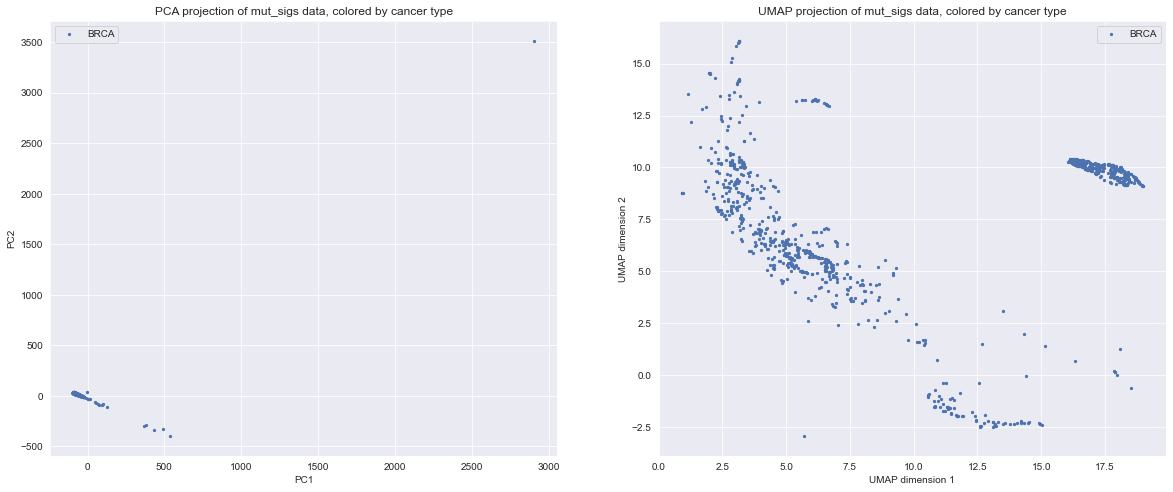

In [4]:
from sklearn.decomposition import PCA
from umap import UMAP

sns.set({'figure.figsize': (20, 8)})
fig, axarr = plt.subplots(1, 2)

assert sample_info_df.index.equals(data_df.index)

pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(data_df)
reducer = UMAP(n_components=2, random_state=42)
X_proj_umap = reducer.fit_transform(data_df)

enum_samples_df = sample_info_df.reset_index()
# data_cancer_types = sorted(sample_info_df.cancer_type.unique())
# data_cancer_types = ['LUAD', 'LUSC', 'THCA', 'LGG', 'GBM', 'BRCA']
data_cancer_types = ['BRCA']
for i, cancer_type in enumerate(data_cancer_types):
    ixs = enum_samples_df.index[enum_samples_df['cancer_type'] == cancer_type].tolist()
    axarr[0].scatter(X_proj_pca[ixs, 0], X_proj_pca[ixs, 1], label=cancer_type, s=5)
    axarr[1].scatter(X_proj_umap[ixs, 0], X_proj_umap[ixs, 1], label=cancer_type, s=5)
    
axarr[0].set_xlabel('PC1')
axarr[0].set_ylabel('PC2')
axarr[0].set_title('PCA projection of {} data, colored by cancer type'.format(DATA_TYPE))
axarr[0].legend()
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].set_title('UMAP projection of {} data, colored by cancer type'.format(DATA_TYPE))
axarr[1].legend()

Now we want to dig a bit deeper into LGG and GBM, using expression and methylation data. It's fairly well-known that IDH1 mutation status defines distinct subtypes in both classes of brain tumors. We'll compare methylation and gene expression in IDH1-mutated vs. non-mutated samples, expecting to see a separation in our low dimensional representation.

IDH1 plays a direct role in DNA methylation, so we anticipate that this separation between mutated and non-mutated samples will be slightly clearer in the methylation data.

In [5]:
# load relevant data
rnaseq_df = du.load_raw_data('expression', verbose=True)
print('Standardizing columns of expression data...', file=sys.stderr)
rnaseq_df[rnaseq_df.columns] = StandardScaler().fit_transform(rnaseq_df[rnaseq_df.columns])

methylation_df = du.load_raw_data('me_27k', verbose=True)
print(methylation_df.shape)
methylation_df.iloc[:5, :5]

Loading expression data...
Standardizing columns of expression data...
Loading me_27k data...


(11975, 20040)


,cg00000292,cg00003994,cg00005847,cg00008493,cg00008713
TCGA-02-0001-01,0.846,0.0664,0.331,0.926,0.0606
TCGA-02-0003-01,0.732,0.1310,0.839,0.934,0.1650
TCGA-02-0006-01,0.679,0.0897,0.469,0.925,0.0616
TCGA-02-0007-01,0.847,0.0409,0.355,0.930,0.0605
TCGA-02-0009-01,0.855,0.0661,0.605,0.927,0.0614


In [6]:
from mpmp.utilities.tcga_utilities import process_y_matrix

def generate_labels(gene, classification):
    # process the y matrix for the given gene or pathway
    y_mutation_df = mutation_df.loc[:, gene]

    # include copy number gains for oncogenes
    # and copy number loss for tumor suppressor genes (TSG)
    include_copy = True
    if classification == "Oncogene":
        y_copy_number_df = copy_gain_df.loc[:, gene]
    elif classification == "TSG":
        y_copy_number_df = copy_loss_df.loc[:, gene]
    else:
        y_copy_number_df = pd.DataFrame()
        include_copy = False

    # construct labels from mutation/CNV information, and filter for
    # cancer types without an extreme label imbalance
    y_df = process_y_matrix(
        y_mutation=y_mutation_df,
        y_copy=y_copy_number_df,
        include_copy=include_copy,
        gene=gene,
        sample_freeze=sample_freeze_df,
        mutation_burden=mut_burden_df,
        filter_count=1,
        filter_prop=0.01,
        output_directory=None,
        hyper_filter=5,
        test=True # don't write filter info to file
    )
    return y_df

In [7]:
gene = 'IDH1'
cancer_types = ['LGG', 'GBM']
classification = du.get_classification(gene, genes_df)
y_df = generate_labels(gene, classification)

y_df = y_df[y_df.DISEASE.isin(cancer_types)]
print(y_df.shape)
y_df.tail()

(628, 5)


,status,PATIENT_BARCODE,DISEASE,SUBTYPE,log10_mut
SAMPLE_BARCODE,,,,,
TCGA-WY-A85A-01,1,TCGA-WY-A85A,LGG,IDHmut-non-codel,1.113943
TCGA-WY-A85B-01,1,TCGA-WY-A85B,LGG,IDHmut-non-codel,1.146128
TCGA-WY-A85C-01,1,TCGA-WY-A85C,LGG,IDHmut-non-codel,1.477121
TCGA-WY-A85D-01,1,TCGA-WY-A85D,LGG,IDHmut-non-codel,1.518514
TCGA-WY-A85E-01,1,TCGA-WY-A85E,LGG,IDHmut-non-codel,1.748188


In [8]:
# generate UMAP 2-dimensional representations of data
shuffle = False

def shuffle_cols(input_df):
    # randomly permute genes of each sample in the rnaseq matrix
    shuf_df = input_df.apply(lambda x:
                             np.random.permutation(x.tolist()),
                             axis=1)
    # set up new dataframe
    shuf_df = pd.DataFrame(shuf_df, columns=['col_list'])
    shuf_df = pd.DataFrame(shuf_df.col_list.values.tolist(),
                           columns=input_df.columns,
                           index=input_df.index)
    return shuf_df

# get samples that are present in all 3 datasets (expression, methylation, mutations)
ix_overlap = y_df.index.intersection(rnaseq_df.index).intersection(methylation_df.index)
y_mut_df = y_df.loc[ix_overlap, :]
rnaseq_mut_df = rnaseq_df.loc[ix_overlap, :]
me_mut_df = methylation_df.loc[ix_overlap, :]

if shuffle:
    rnaseq_mut_df = shuffle_cols(rnaseq_mut_df)
    me_mut_df = shuffle_cols(me_mut_df)
    
reducer = UMAP(n_components=2, random_state=42)
X_proj_rnaseq = reducer.fit_transform(rnaseq_mut_df)
X_proj_me = reducer.fit_transform(me_mut_df)
print(X_proj_rnaseq.shape)
print(X_proj_me.shape)

(628, 2)
(628, 2)


In [9]:
gene_label = '{} mutant'.format(gene)
me_proj_df = pd.DataFrame({
    'UMAP1': X_proj_me[:, 0],
    'UMAP2': X_proj_me[:, 1],
    'Cancer type': y_mut_df.DISEASE.values,
    gene_label: y_mut_df.status.values.astype('bool')
})
rnaseq_proj_df = pd.DataFrame({
    'UMAP1': X_proj_rnaseq[:, 0],
    'UMAP2': X_proj_rnaseq[:, 1],
    'Cancer type': y_mut_df.DISEASE.values,
    gene_label: y_mut_df.status.values.astype('bool')
})
me_proj_df.head()

,UMAP1,UMAP2,Cancer type,IDH1 mutant
0,-2.231673,11.387752,GBM,False
1,-1.248729,12.348688,GBM,False
2,8.924399,9.308194,GBM,True
3,-3.601400,12.036440,GBM,False
4,-3.734838,12.177651,GBM,False


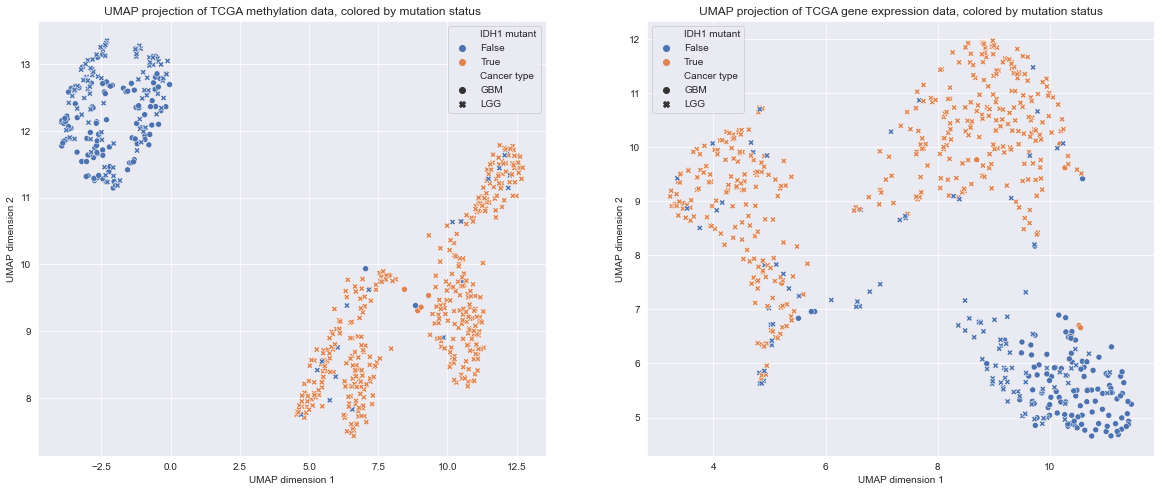

In [10]:
sns.set({'figure.figsize': (20, 8)})
fig, axarr = plt.subplots(1, 2)

sns.scatterplot(x='UMAP1', y='UMAP2', data=me_proj_df, hue=gene_label,
                style='Cancer type', ax=axarr[0])
axarr[0].set_xlabel('UMAP dimension 1')
axarr[0].set_ylabel('UMAP dimension 2')
axarr[0].set_title('UMAP projection of TCGA methylation data, colored by mutation status')
axarr[0].legend()
sns.scatterplot(x='UMAP1', y='UMAP2', data=rnaseq_proj_df, hue=gene_label,
                style='Cancer type', ax=axarr[1])
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].set_title('UMAP projection of TCGA gene expression data, colored by mutation status')
axarr[1].legend()

As expected, we can see that there's a nice separation between (most) IDH1 mutants and non-mutants in the methylation data. They separate to some degree in the gene expression data, but not quite as clearly.

It's likely (although I haven't checked this yet) that the non-mutated samples in the IDH1-mutant methylation cluster are actually IDH2 mutants. IDH2 is thought to phenocopy IDH1 in gliomas, having a similar effect on methylation and gene expression as IDH1 when mutated.